In [1]:
!pip install yfinance --quiet

     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install -U vectorbt --quiet

     |████████████████████████████████| 479 kB 5.1 MB/s 
     |████████████████████████████████| 288 kB 50.6 MB/s 
     |████████████████████████████████| 3.4 MB 51.8 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
     |████████████████████████████████| 749 kB 71.7 MB/s 


In [3]:
!pip install -U kaleido --quiet

     |████████████████████████████████| 79.9 MB 89 kB/s 


In [4]:
import warnings
import vectorbt as vbt
warnings.filterwarnings('ignore')
%matplotlib inline

### **MACD Indicator** (Moving Average Convergence Divergence)

Analyzes the convergence and divergence between two moving averages to try to identify price trends. It consists of the MACD line, a signal line and histogram. We can generate buy and sell signals from crossing the lines.

Crosses of the MACD line with the signal line can indicate an uptrend, while if the signal line is above the MACD line, it can be an indicator of a downtrend.

In [6]:
# VALE company details
data = vbt.YFData.download('VALE3.SA').get()

In [7]:
data.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00+00:00,1.795995,1.817803,1.795995,1.795995,585600,0.0,0.0
2000-01-04 00:00:00+00:00,1.778890,1.782738,1.753233,1.753233,782400,0.0,0.0
2000-01-05 00:00:00+00:00,1.731852,1.753233,1.731852,1.753233,1876800,0.0,0.0


OHLC (Candlestick) Chart, i.e. Open (**O**), High (**H**), Low (**L**) and Close (**C**)

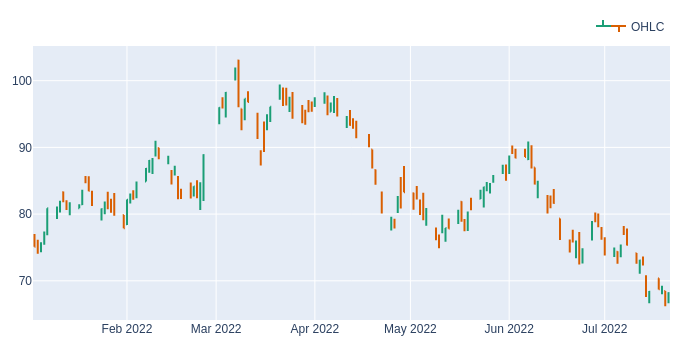

In [8]:
data['2022'].vbt.ohlcv.plot(show_volume=False).show_png()

***
### MACD


- MACD Line: Difference between a short moving average and a long moving average. 
- Signal line: moving average formed by the MACD line itself. 
- MACD Histogram: Visual representation of the difference between the MACD line value and the signal line

In [9]:
closing = data['Close'] # Closing price

**Getting MACD lines**

    Short average: 12
    long average: 26
    Average signal line: 9

In [10]:
macd = vbt.MACD.run(closing, fast_window=12, slow_window=26, signal_window=9)

We can call the plot function of the macd object to visualize the lines and histogram

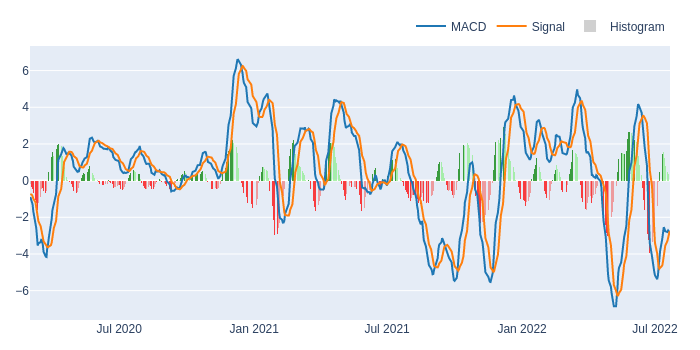

In [11]:
macd['2020-03':].plot().show_png()

It is also possible to directly access the values ​​of the lines created in the MACD execution

In [12]:
macd_line = macd.macd # MACD Line
macd_line.tail(3)

Date
2022-07-19 00:00:00+00:00   -2.718461
2022-07-20 00:00:00+00:00   -2.767820
2022-07-21 00:00:00+00:00   -2.757500
Name: (12, 26, 9, Close), dtype: float64

In [14]:
signal_line = macd.signal # signal line
signal_line.tail(3)

Date
2022-07-19 00:00:00+00:00   -3.057087
2022-07-20 00:00:00+00:00   -2.881994
2022-07-21 00:00:00+00:00   -2.761089
Name: (12, 26, 9, Close), dtype: float64

In [15]:
histogram = macd.hist # Histogram MACD
histogram.tail(3)

Date
2022-07-19 00:00:00+00:00    0.338626
2022-07-20 00:00:00+00:00    0.114174
2022-07-21 00:00:00+00:00    0.003590
Name: (12, 26, 9, Close), dtype: float64

In [16]:
# Signal line longer than MACD line?
signal_line > macd_line

Date
2000-01-03 00:00:00+00:00    False
2000-01-04 00:00:00+00:00    False
2000-01-05 00:00:00+00:00    False
2000-01-06 00:00:00+00:00    False
2000-01-07 00:00:00+00:00    False
                             ...  
2022-07-15 00:00:00+00:00    False
2022-07-18 00:00:00+00:00    False
2022-07-19 00:00:00+00:00    False
2022-07-20 00:00:00+00:00    False
2022-07-21 00:00:00+00:00    False
Name: (12, 26, 9, Close), Length: 5667, dtype: bool

***

### Strategy

* **BUY** (= +1) when MACD is above zero AND signal line
* **SELL** (= -1) when MACD is below zero OR signal line

Source: https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/macd#:~:text=When%20the%20MACD%20line%20crosses,line%20the%20stronger%20the%20signal.

In [17]:
buy = macd.macd_above(0) & macd.macd_above(macd.signal)
sell = macd.macd_below(0) | macd.macd_below(macd.signal)

Let's now run the backtest passing the asset's price history and the entry (buy) and exit (sell) points.

I set the data frequency to daily (freq='d').

In [18]:
pf = vbt.Portfolio.from_signals(closing, buy, sell, freq='d')

As a result, we have a total return of 81.14 , that means that in the end, added to the initial investment of 100.00, we would have 181.14

In [19]:
pf.stats()[['Start', 'End', 'Period', 'Start Value', 'End Value', 'Total Return [%]']]

Start               2000-01-03 00:00:00+00:00
End                 2022-07-21 00:00:00+00:00
Period                     5667 days 00:00:00
Start Value                             100.0
End Value                          181.148151
Total Return [%]                    81.148151
dtype: object

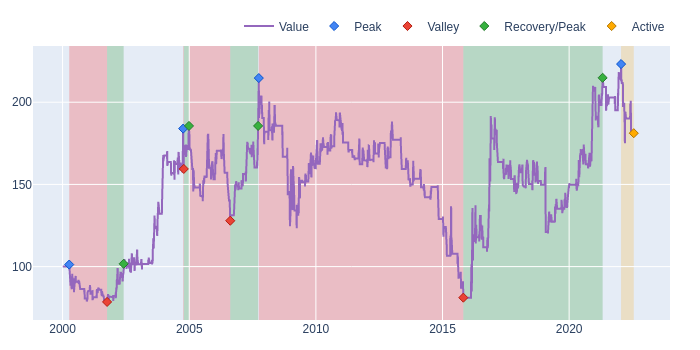

In [20]:
pf.plot_drawdowns().show_png()

###Cumulative return

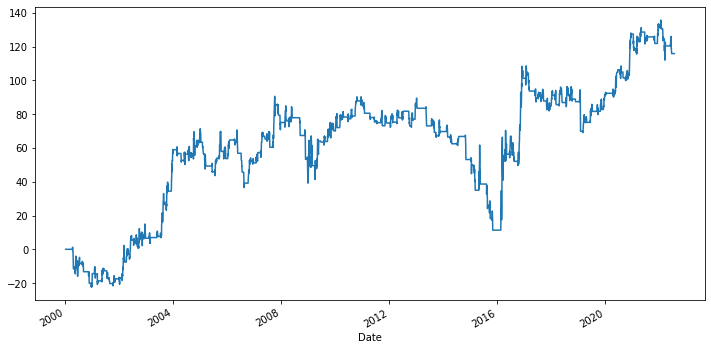

In [21]:
(pf.returns().cumsum() * 100).plot(figsize=(12,6))